# Import The Dependencies

In [1]:
%pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.29 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5689.3/8062.4 GB disk)


# Train the model

#### I had used YOLOv8 CLI approach, it can also be done with provided python APIs

In [2]:
!yolo train model=yolov8s.pt data=/kaggle/working/my-leaf-ds-yolo/data.yaml batch=16 plots=True time=11 epochs=300 imgsz=640

Ultralytics YOLOv8.2.28 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/leaf-ds4-yolo/data.yaml, epochs=300, time=11, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

# Model Evaluation

In [4]:

!yolo val model=/kaggle/working/runs/detect/train/weights/best.pt data=/kaggle/working/my-leaf-ds-yolo/data.yaml imgsz=640 batch=16 device=0


Ultralytics YOLOv8.2.28 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /kaggle/working/my-leaf-ds-yolo/valid/labels.cache... 8501 images, 0 
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        8501       4092      0.819      0.842      0.899      0.825
Speed: 0.5ms preprocess, 8.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


# Testing The model (Making Inferences)

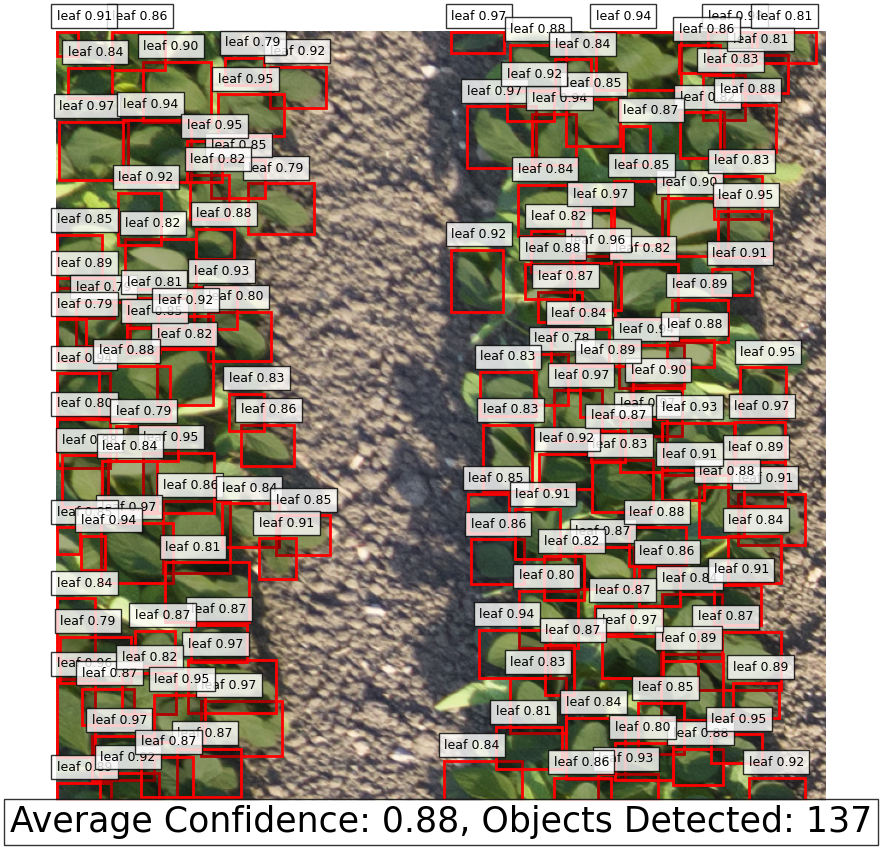

In [122]:
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import numpy as np

# define some colors 
bg_color =  (0, 0, 0, 0.3)
border_color=(1.00, 0.00, 0.00)
text_color='black'


# load my trained model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt') 

# load my test image to make prediction
image_path = '/kaggle/input/test_images/segment_1.png'
image = Image.open(image_path)

# make the prediction
results = model(image)

# plot/visualize the result
img_np = np.array(image)
plt.figure(figsize=(10, 10))
plt.imshow(img_np)

for result in results[0].boxes:
    x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()
    #get confidence score
    conf = result.conf.cpu().numpy().item()
    cls = result.cls.cpu().numpy().item()
    #get label <--> class name
    label = model.names[int(cls)]
        
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                          edgecolor=border_color, facecolor=bg_color, linewidth=2))
    plt.text(x1, y1 - 10, f'{label} {conf:.2f}', color=text_color, fontsize=9,
            bbox=dict(facecolor='white', alpha=0.8))


confidences = [result.conf.cpu().numpy().item() for result in results[0].boxes]
average_confidence=sum(confidences) / len(confidences)
num_objects=len(confidences)
text_color = 'black'
text_bg_color = (1,1,1)
plt.text(0.5, -0.005, f'Average Confidence: {average_confidence:.2f}, Objects Detected: {num_objects}',
         ha='center', va='top', fontsize=25, color=text_color, 
         bbox=dict(facecolor=text_bg_color, alpha=0.8),transform=plt.gca().transAxes)

plt.axis('off')
plt.show()

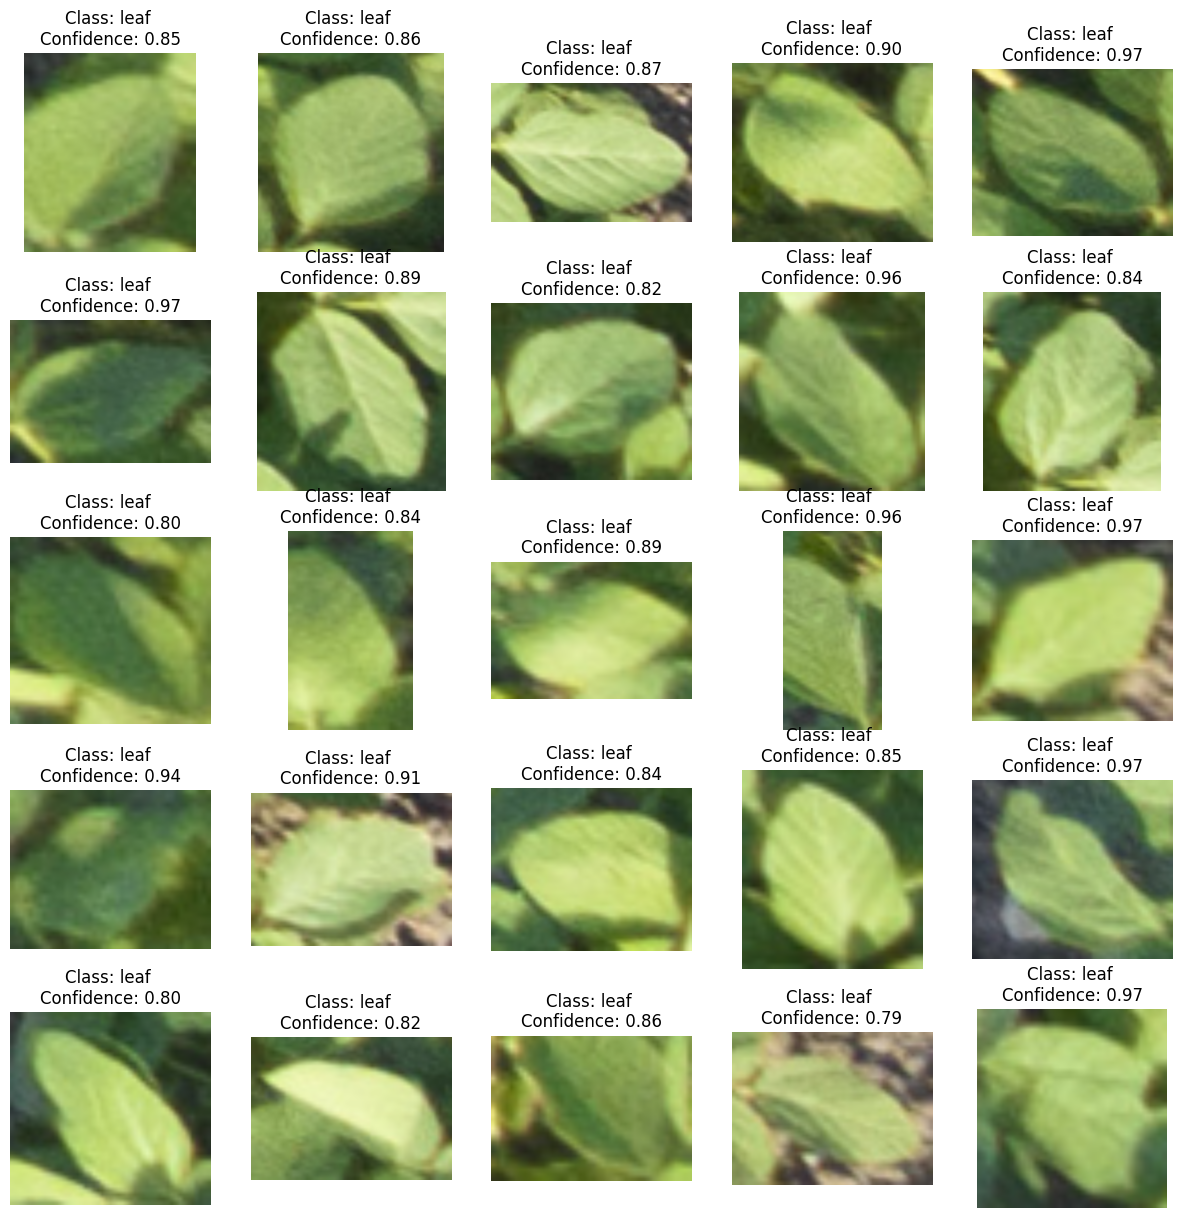

In [123]:

# Display First 25 detected leaves

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    
bbox_count = 0
    
for result in results[0].boxes:
    if bbox_count >= 25:
        break
        
    x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()
    conf = result.conf.cpu().numpy().item()
    cls = result.cls.cpu().numpy().item()
    label = model.names[int(cls)]

    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
        
    # Extract the bounding box region from the original image
    bbox_region = img_np[y1:y2, x1:x2]
                
    row = bbox_count // 5
    col = bbox_count % 5
    axs[row, col].imshow(bbox_region)
    axs[row, col].axis('off')
    axs[row, col].set_title(f"Class: {label} \nConfidence: {conf:.2f}")
        
    bbox_count += 1
    
for i in range(bbox_count, 25):
    row = i // 5
    col = i % 5
    axs[row, col].axis('off')


plt.show()